# Mixed Calibration of model parameters: TSLA
### European calls and puts and otko daily cliquet options

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.optimize as scpo
import sys
import time
import warnings
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')
warnings.simplefilter(action='ignore', category=FutureWarning)

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

Let's read the dataframe of european call and put options. A **subset** of options has been already selected in the module  `plainvanilla.py`.

In [2]:
calls_tsla = pd.read_csv('../../data/TSLA/OPT16_TSLA_CALLS_50_150.csv')
moneyness = [0.75, 0.86, 0.98, 1.01, 1.16, 1.31]
cond = calls_tsla['MONEYNESS'].isin(moneyness)
calls = calls_tsla[cond].copy()
calls.reset_index(drop=True, inplace=True)
print(calls)

   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  C_BID  C_ASK  STRIKE     C_IV  \
0  2016-01-20            198.7  2017-01-20  58.64  60.81   150.0  0.52003   
1  2016-01-20            198.7  2017-01-20  46.79  48.40   170.0  0.50543   
2  2016-01-20            198.7  2017-01-20  34.09  35.81   195.0  0.48620   
3  2016-01-20            198.7  2017-01-20  31.90  33.65   200.0  0.48345   
4  2016-01-20            198.7  2017-01-20  21.55  24.29   230.0  0.48005   
5  2016-01-20            198.7  2017-01-20  13.51  15.35   260.0  0.45443   

   MONEYNESS  
0       0.75  
1       0.86  
2       0.98  
3       1.01  
4       1.16  
5       1.31  


In [3]:
puts_tsla = pd.read_csv('../../data/TSLA/OPT16_TSLA_PUTS_50_150.csv')
moneyness =  [0.75, 0.83, 0.98, 1.01, 1.11, 1.26]
cond = puts_tsla['MONEYNESS'].isin(moneyness)
puts = puts_tsla[cond].copy()
puts.reset_index(drop=True, inplace=True)
print(puts)

   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  P_BID  P_ASK  STRIKE     P_IV  \
0  2016-01-20            198.7  2017-01-20  18.55  19.94   150.0  0.53022   
1  2016-01-20            198.7  2017-01-20  24.55  25.80   165.0  0.51357   
2  2016-01-20            198.7  2017-01-20  39.16  40.60   195.0  0.48464   
3  2016-01-20            198.7  2017-01-20  42.10  43.70   200.0  0.48296   
4  2016-01-20            198.7  2017-01-20  54.46  56.00   220.0  0.46666   
5  2016-01-20            198.7  2017-01-20  75.66  76.64   250.0  0.44105   

   MONEYNESS  
0       0.75  
1       0.83  
2       0.98  
3       1.01  
4       1.11  
5       1.26  


Let's initialize the values for our calibration.

In [4]:
q = 0           # dividend yield
r = 0.03        # risk-free interest rate
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
exercise = 'european'

calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']
calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
calls_strikes = calls['STRIKE']    # array of K for call options
calls_prices = calls['C_Midpoint']
calls_spreads = calls['C_Spread']
calls_weights = 1/calls_spreads**2

In [5]:
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']
puts_strikes = puts['STRIKE']    # array of K for call options
puts_prices = puts['P_Midpoint']
puts_spreads = puts['P_Spread']
weights = 1/puts_spreads**2

In [6]:
otko_tsla = pd.read_csv('../../data/TSLA/tsla_otko_1year.csv')
scale_factors = {
    'APL': 7.84,
    'META': 6.23,
    'TSLA': 10.35,
    'NVDA': 10.7
}

th_prices = pd.DataFrame({
    'K1': otko_tsla['K1'],
    'K2': otko_tsla['K2'],
    'Midpoint (%)': otko_tsla['Midpoint(%)']
})
print(otko_tsla)
th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

otko_strikes = otko_tsla[['K1', 'K2']].values / 100
otko_spreads =  otko_tsla['ASK(%)'] - otko_tsla['BID(%)']
otko_weights = 1/(otko_spreads) **2
otko_mkt_prices = otko_tsla['Midpoint(%)'].values

  Starting date Stock Name Expiry  K1  K2  BID(%)  Midpoint(%)  ASK(%)
0    20/01/2016       TSLA     1Y  75   0    1.76         1.91    2.07
1    20/01/2016       TSLA     1Y  70   0    0.83         0.93    1.03
2    20/01/2016       TSLA     1Y  85  75    3.52         3.83    4.14
3    20/01/2016       TSLA     1Y  80  70    2.48         2.69    2.90
4    20/01/2016       TSLA     1Y  90  80    4.97         5.28    5.59


Then, we create the objects of the classes that develop the desired models. We initialize them with the parameters calibrated on calls prices.

In [7]:
%store -r calls_bs_params_tsla
%store -r calls_mert_params_tsla
%store -r calls_kou_params_tsla
%store -r calls_vg_params_tsla

%store -r puts_bs_params_tsla
%store -r puts_mert_params_tsla
%store -r puts_kou_params_tsla
%store -r puts_vg_params_tsla

%store -r otko_mert_params_tsla
%store -r otko_kou_params_tsla
%store -r otko_vg_params_tsla

In [8]:
bs_param = calls_bs_params_tsla
bs_param = puts_bs_params_tsla

m_params_calls = calls_mert_params_tsla
m_params_puts = puts_mert_params_tsla
m_params_otko = otko_mert_params_tsla

k_params_calls = calls_kou_params_tsla
k_params_puts = puts_kou_params_tsla
k_params_otko = otko_kou_params_tsla

vg_params_calls = calls_vg_params_tsla
vg_params_puts = puts_vg_params_tsla
vg_params_otko = otko_vg_params_tsla

### Option pricing calibration on the full set of options

#### Merton Jump Diffusion model

In [9]:
x0 = [0.25, 1, -0.05, 1.2]    # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 0, -2, 0], [1, 5, 4, 5] )

def cost_function(x, c_strikes, c_mkt_prices, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err1 = np.sum((M.closed_formula_call(c_strikes) - c_mkt_prices)**2)
    sq_err2 = np.sum((M.closed_formula_put(p_strikes) - p_mkt_prices)**2)
    sq_err = sq_err1 + sq_err2 
    for k in range(len(o_strikes)):
        sq_err +=  (M.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, puts_strikes, puts_prices, otko_strikes, otko_mkt_prices), bounds=bounds, method = 'trf', verbose=2)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8606e+09                                    1.60e+10    
       1              2         5.1566e+08      1.34e+09       2.06e+00       8.07e+09    
       2              3         4.0417e+07      4.75e+08       5.37e-01       3.07e+08    
       3              4         1.7569e+07      2.28e+07       1.26e-01       1.31e+08    
       4              5         3.1209e+06      1.44e+07       3.43e-01       1.92e+07    
       5              7         1.1220e+06      2.00e+06       9.76e-02       8.14e+06    
       6              8         3.9031e+05      7.32e+05       3.40e-01       2.89e+06    
       7             11         3.5388e+05      3.64e+04       4.23e-02       1.62e+06    
       8             12         3.2814e+05      2.57e+04       3.55e-02       1.33e+06    
       9             13         2.9484e+05      3.33e+04       7.56e-02       4.29e+05    

In [10]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.4226 	 42.26%
> Calibrated Jump intensity [λ] =  0.11
> Calibrated Jump Mean =  -0.648
> Calibrated Jump St. dev.  =  1.033
TIME ELAPSED:  208.16 sec


In [11]:
print(mert_params_calibrated)
mixed_mert_params_tsla = mert_params_calibrated
m_params_mixed = mert_params_calibrated
%store mixed_mert_params_tsla

[0.4226, 0.1055, -0.6481, 1.0329]
Stored 'mixed_mert_params_tsla' (list)


#### Kou Jump Diffusion Model

In [12]:
x0 = [0.24, 1.5, 0.5, 7.5, 5]   # initial guess: [σ, λ, p, η_1, η_2]
# x0 =[0.1447, 0.9, 0.7, 2.5685, 7.75]
bounds = ( [1e-2, 1e-2, 0, 0, 0], [1, 5, 0.999,  15, 20] )

# Define the objective function
def cost_function(x, c_strikes, c_mkt_prices, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=c_strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err1 = np.sum((KOU.closed_formula_call(c_strikes) - c_mkt_prices) ** 2)
    sq_err2 = np.sum((KOU.closed_formula_put(p_strikes) - p_mkt_prices) ** 2)
    sq_err = sq_err2 + sq_err1
    for k in range(len(o_strikes)):
        sq_err += (KOU.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, ftol=1e-7, verbose=2)
end2 =time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4576e+06                                    1.47e+07    
       1              2         2.0093e+05      1.26e+06       8.25e+00       4.35e+05    
       2              6         1.9487e+05      6.06e+03       9.80e-03       1.28e+05    
       3              8         1.9436e+05      5.09e+02       2.43e-03       5.80e+04    
       4              9         1.9424e+05      1.28e+02       2.62e-03       3.19e+04    
       5             11         1.9423e+05      9.81e+00       1.42e-03       3.16e+04    
       6             12         1.9422e+05      8.96e+00       2.23e-03       3.35e+04    
       7             13         1.9421e+05      8.27e+00       2.37e-03       3.20e+04    
       8             14         1.9420e+05      8.61e+00       2.10e-03       3.66e+04    
       9             15         1.9419e+05      4.74e+00       1.93e-03       2.54e+04    

In [13]:
kou_params_calibrated = [round(p,4) for p in kou.x[:5]]

In [14]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
#print(f'> Calibrated Volatlity [σ] = 0.132 \t 13.2%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.4438 	 44.38%
> Calibrated Jump intensity [λ] =  3.23
> Calibrated Upward Jump probability [p] = 0.05, [q] = 0.95
> Calibrated Rate of Exp. 1  [η_1] =  10.11
> Calibrated Rate of Exp. 2  [η_2] =  11.56
TIME ELAPSED:  11708.42 sec


In [15]:
print(kou_params_calibrated)
mixed_kou_params_tsla = kou_params_calibrated
k_params_mixed = kou_params_calibrated
%store mixed_kou_params_tsla

[0.4438, 3.2273, 0.0451, 10.1057, 11.5584]
Stored 'mixed_kou_params_tsla' (list)


#### Variance gamma model

In [16]:
x0 = [0.4, 0.08, 0.5]
bounds = ( [0.05, -0.17, 0], [0.9, 1.5, 2] )


def cost_function(x, c_strikes, c_mkt_prices, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    c_prices = []; p_prices = []
    
    for k in c_strikes:
        c_prices.append(VG.closed_formula_call(k))
    sq_err1 = np.sum((c_prices - c_mkt_prices)**2)
    
    for k in p_strikes:
        p_prices.append(VG.closed_formula_call(k))
    sq_err2 = np.sum((p_prices - p_mkt_prices)**2)
    
    sq_err = sq_err1 + sq_err2
    for k in range(len(o_strikes)):
        sq_err += (VG.closed_formula_otko8(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(calls_strikes, calls_prices, puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2, tr_solver='exact', max_nfev=400)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6052e+07                                    3.91e+07    
       1              3         2.2383e+07      3.67e+06       7.19e-02       8.13e+06    
       2              4         2.2276e+07      1.07e+05       6.23e-02       1.49e+07    
       3              5         2.1826e+07      4.50e+05       1.83e-02       7.47e+06    
       4              6         2.1512e+07      3.14e+05       3.63e-02       3.34e+06    
       5              7         2.1217e+07      2.96e+05       3.11e-02       4.68e+06    
       6              8         2.0931e+07      2.86e+05       3.75e-02       3.99e+06    
       7              9         2.0641e+07      2.90e+05       3.33e-02       5.12e+06    
       8             10         2.0356e+07      2.85e+05       3.86e-02       4.68e+06    
       9             11         2.0075e+07      2.81e+05       3.49e-02       5.29e+06    

In [17]:
print('METHOD: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD: LEAST-SQUARES (trf)
> Calibrated Volatility [σ] = 0.3252, 	 32.52%
> Calibrated mean rate gamma process [θ] =  -0.17
> Calibrated variance rate gamma process [v]=  1.9983
TIME ELAPSED:  482.96 sec


In [18]:
print(vg_params_calibrated)
mixed_vg_params_tsla = vg_params_calibrated
vg_params_mixed = vg_params_calibrated
%store mixed_vg_params_tsla

[0.3252, -0.17, 1.9983]
Stored 'mixed_vg_params_tsla' (list)


### RESULTS FROM CALIBRATION
This section aims to reprice the options used for calibration. On this purpose, both calls and otko prices obtained by each model are compared to the original market prices, starting point of our calibration process.

In [19]:
days = 252
paths = 5000

#CALLS PRICES
calls_calib_prices = pd.DataFrame({
    'STRIKE': calls['STRIKE'],    # array of K for call options
    'MKT_BID': calls['C_BID'],
    'MKT_MID': calls['C_Midpoint'],
    'MKT_ASK': calls['C_ASK'],
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n>CALLS:\n{calls_calib_prices}\n')

#PUTS PRICES
puts_calib_prices = pd.DataFrame({
    'STRIKE': puts['STRIKE'],    # array of K for call options
    'MKT_BID': puts['P_BID'],
    'MKT_MID': puts['P_Midpoint'],
    'MKT_ASK': puts['P_ASK'],
})
print(f'\n>PUTS:\n{puts_calib_prices}\n')

# OTKO PRICES
otko_calib_prices = pd.DataFrame({
    'K1': otko_tsla['K1'],
    'K2': otko_tsla['K2'],
    'MKT_BID (%)': otko_tsla['BID(%)'],
    'MKT_MID (%)': otko_tsla['Midpoint(%)'],
    'MKT_ASK (%)': otko_tsla['ASK(%)']
})
print(f'\n>OTKO:\n{otko_calib_prices}\n')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 
>CALLS:
   STRIKE  MKT_BID  MKT_MID  MKT_ASK
0   150.0    58.64   59.725    60.81
1   170.0    46.79   47.595    48.40
2   195.0    34.09   34.950    35.81
3   200.0    31.90   32.775    33.65
4   230.0    21.55   22.920    24.29
5   260.0    13.51   14.430    15.35


>PUTS:
   STRIKE  MKT_BID  MKT_MID  MKT_ASK
0   150.0    18.55   19.245    19.94
1   165.0    24.55   25.175    25.80
2   195.0    39.16   39.880    40.60
3   200.0    42.10   42.900    43.70
4   220.0    54.46   55.230    56.00
5   250.0    75.66   76.150    76.64


>OTKO:
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0         1.76         1.91         2.07
1  70   0         0.83         0.93         1.03
2  85  75         3.52         3.83         4.14
3  80  70         2.48         2.69         2.90
4  90  80         4.97         5.28         5.59



#### Merton Jump Diffusion

CALIBRATED PARAMETERS [σ		λ		m		v]
> European CALLS:	 [0.3062, 0.9971, 0.0544, 0.2319]
> European PUTS:	 [0.5703, 0.2216, -0.3232, 0.1781]
> OTKO DC:			 [0.3152, 1.9192, -0.1366, 0.1707]
> MIXED:		 [0.4226, 0.1055, -0.6481, 1.0329]


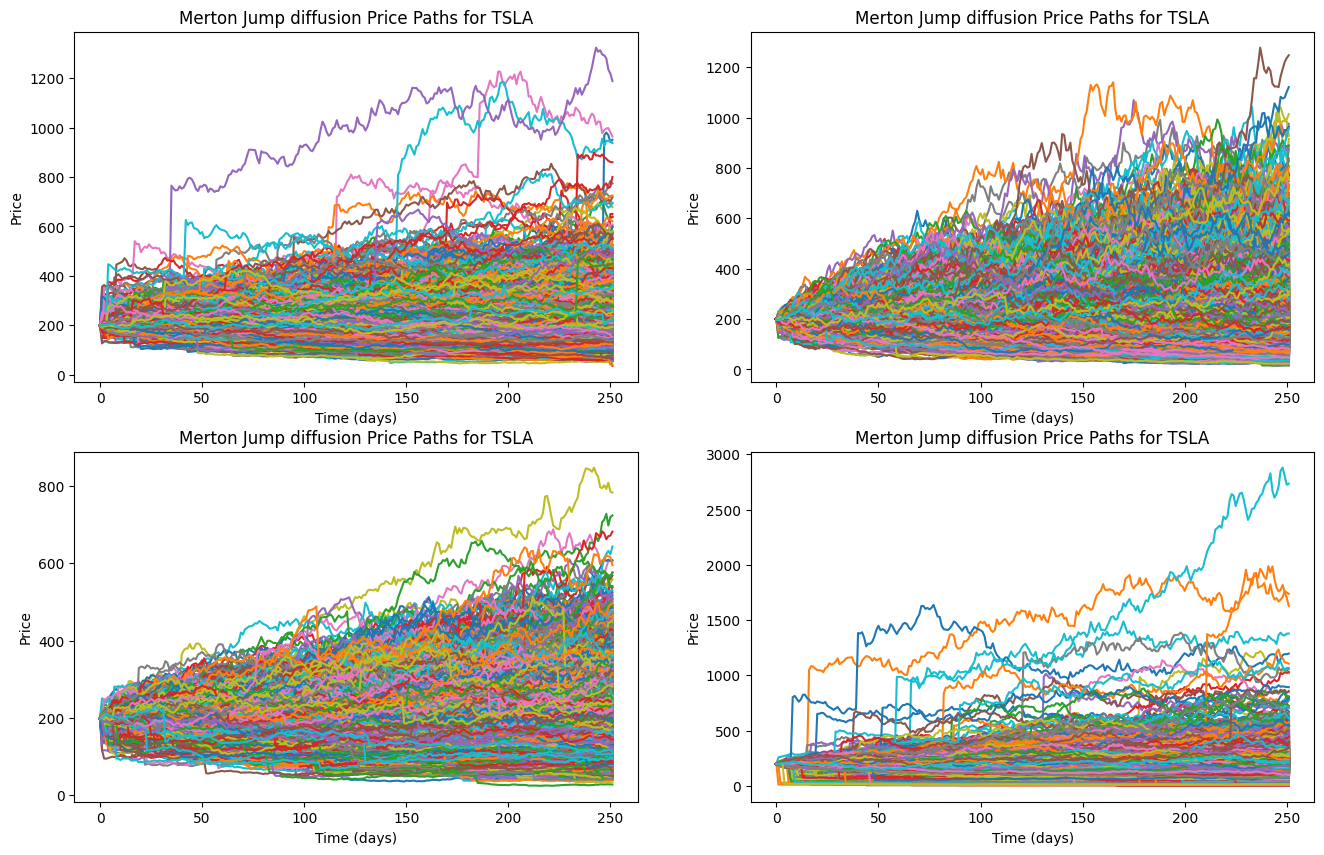

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

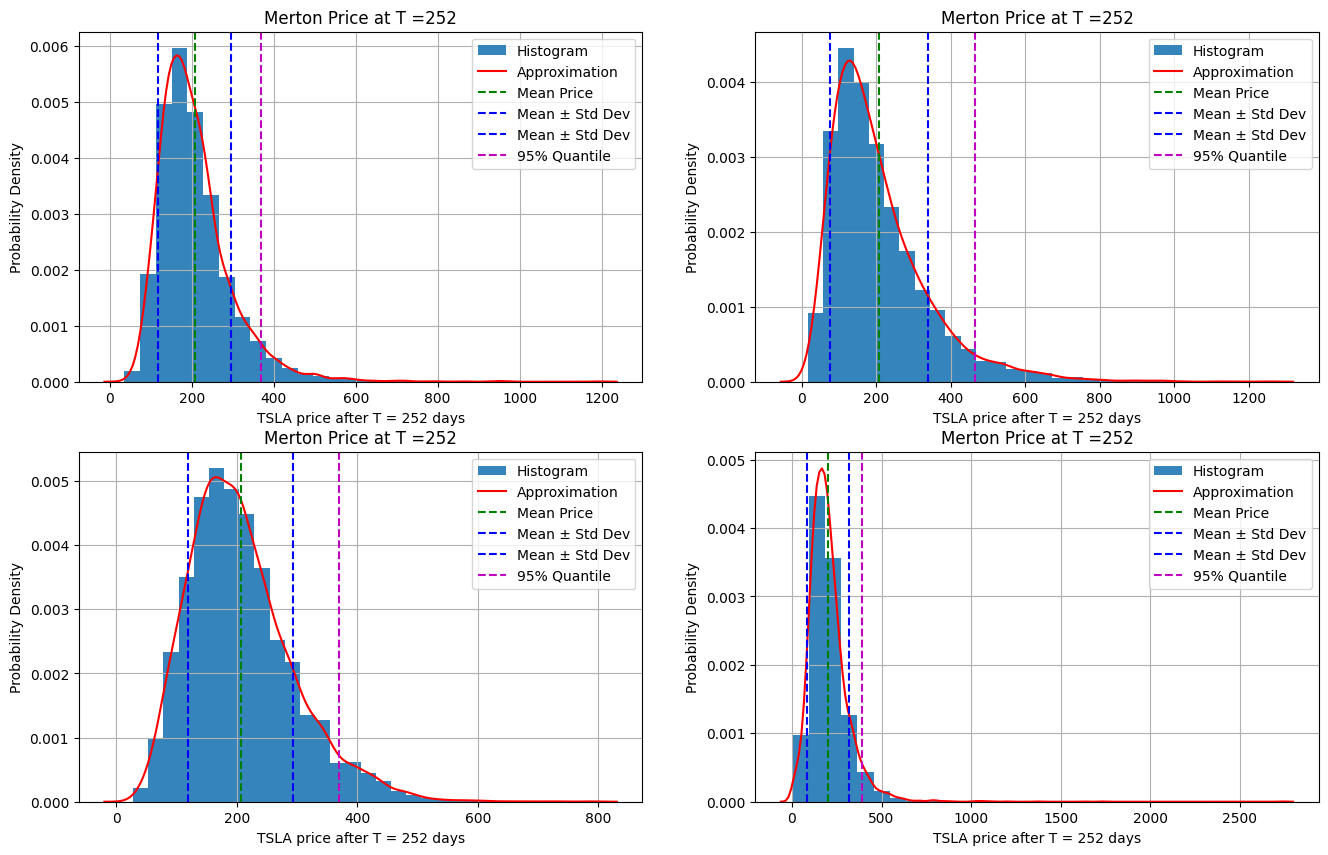

In [20]:
print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> European CALLS:\t {m_params_calls}')
print(f'> European PUTS:\t {m_params_puts}')
print(f'> OTKO DC:\t\t\t {m_params_otko}')
print(f'> MIXED:\t\t {m_params_mixed}')

Merton1 = Merton_pricer(S0, None, T, r, q, m_params_calls[0], m_params_calls[1], m_params_calls[2], m_params_calls[3], exercise)
Merton2 = Merton_pricer(S0, None, T, r, q, m_params_puts[0], m_params_puts[1], m_params_puts[2], m_params_puts[3], exercise)
Merton3 = Merton_pricer(S0, None, T, r, q, m_params_otko[0], m_params_otko[1], m_params_otko[2], m_params_otko[3], exercise)
Merton4 = Merton_pricer(S0, None, T, r, q, m_params_mixed[0], m_params_mixed[1], m_params_mixed[2], m_params_mixed[3], exercise)

SMerton1 = Merton1.MertonPath(days, paths)
SMerton2 = Merton2.MertonPath(days, paths)
SMerton3 = Merton3.MertonPath(days, paths)
SMerton4 = Merton4.MertonPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
Merton1.plotMertonPath(SMerton1, 'TSLA', ax=axes[0,0])
Merton2.plotMertonPath(SMerton2, 'TSLA', ax=axes[0,1])
Merton3.plotMertonPath(SMerton3, 'TSLA', ax=axes[1,0])
Merton4.plotMertonPath(SMerton4, 'TSLA', ax=axes[1,1])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
Merton1.plotMertonAtFixedTime(SMerton1, days-1, 'TSLA', ax = axes[0,0])
Merton2.plotMertonAtFixedTime(SMerton2, days-1, 'TSLA', ax = axes[0,1])
Merton3.plotMertonAtFixedTime(SMerton3, days-1, 'TSLA', ax = axes[1,0])
Merton4.plotMertonAtFixedTime(SMerton4, days-1, 'TSLA', ax = axes[1,1])

Then we show our options priced by the Merton model, using the parameters calibrated on the full set of European calls and One Touch Knockout Daily Cliquets.

In [21]:
avg_payoffs = []
for k in calls_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton3[-1]:
        payoffs.append(Merton4.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(calls_calib_prices))
merton_cf_prices = np.zeros(len(calls_calib_prices))

for index in range(len(calls_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = Merton4.closed_formula_call(calls_strikes[index])

calls_calib_prices['MERTON MC (%)'] = merton_mc_prices
calls_calib_prices['MERTON CF (%)'] = merton_cf_prices

avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton4[-1]:
        payoffs.append(Merton4.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(puts_calib_prices))
merton_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = Merton4.closed_formula_put(puts_strikes[index])

puts_calib_prices['MERTON MC (%)'] = merton_mc_prices
puts_calib_prices['MERTON CF (%)'] = merton_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton3.T:
        payoffs.append(Merton4.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(otko_calib_prices))
merton_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = Merton3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['MERTON MC (%)'] = merton_mc_prices
otko_calib_prices['MERTON CF (%)'] = merton_cf_prices

print(calls_calib_prices)
print('\n')
print(puts_calib_prices)
print('\n')
print(otko_calib_prices)

   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)
0   150.0    58.64   59.725    60.81      64.476455      66.795521
1   170.0    46.79   47.595    48.40      51.464026      54.713572
2   195.0    34.09   34.950    35.81      37.951983      42.320761
3   200.0    31.90   32.775    33.65      35.613930      40.181192
4   230.0    21.55   22.920    24.29      24.041279      29.435808
5   260.0    13.51   14.430    15.35      15.909248      21.696871


   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)
0   150.0    18.55   19.245    19.94      13.686155      13.662351
1   165.0    24.55   25.175    25.80      19.031725      18.972486
2   195.0    39.16   39.880    40.60      32.955906      32.857640
3   200.0    42.10   42.900    43.70      35.710617      35.570299
4   220.0    54.46   55.230    56.00      47.751832      47.441743
5   250.0    75.66   76.150    76.64      68.502462      67.902833


   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON M

### Kou Jump Diffusion

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> European CALLS:	 [0.3547, 0.9235, 0.5685, 7.8424, 10.0337]
> European PUTS:	  [0.5, 2.3029, 0.6032, 6.0878, 14.2463]
> OTKO DC:			 [0.386      5.87055475 0.2        8.5        9.38813699]
> MIXED:				 [0.4438, 3.2273, 0.0451, 10.1057, 11.5584]


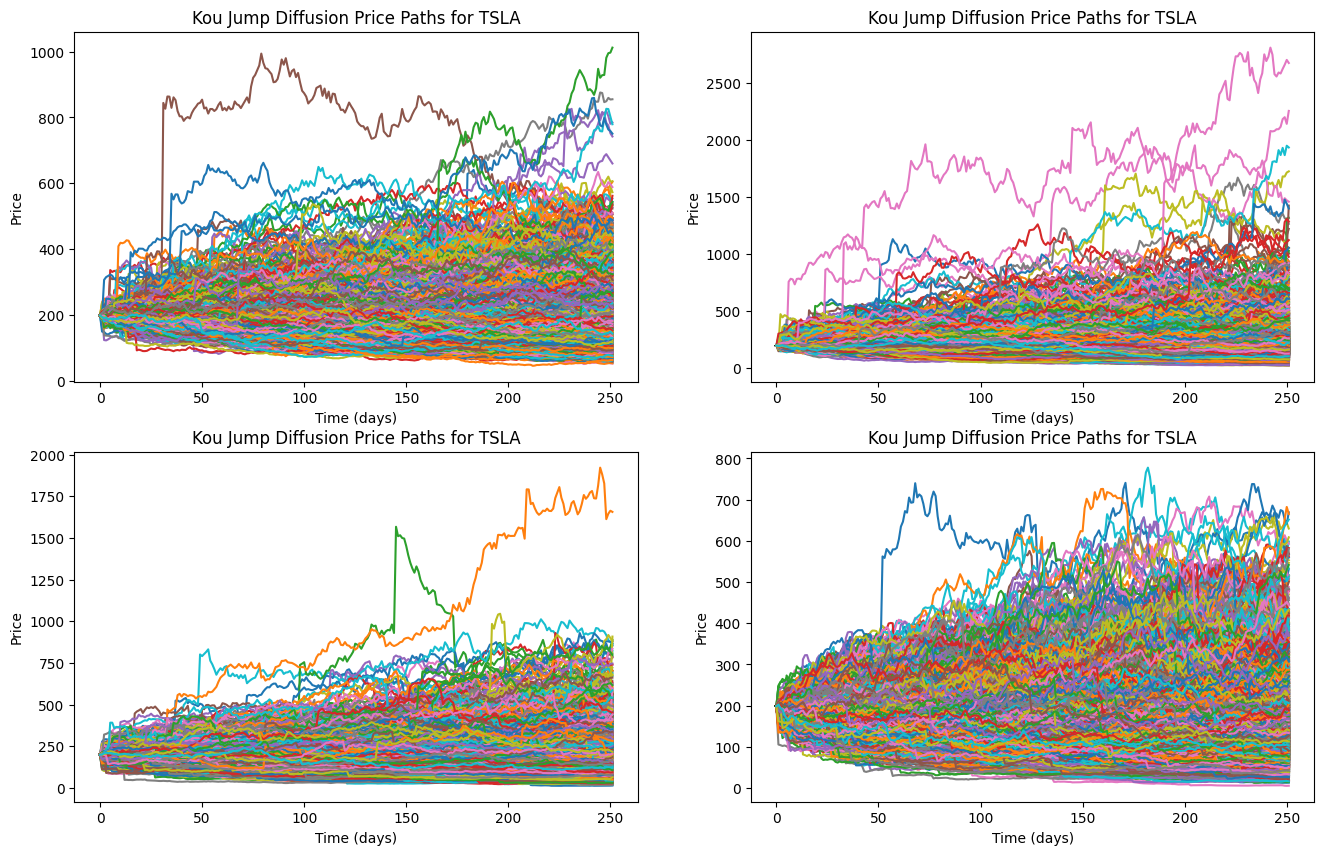

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

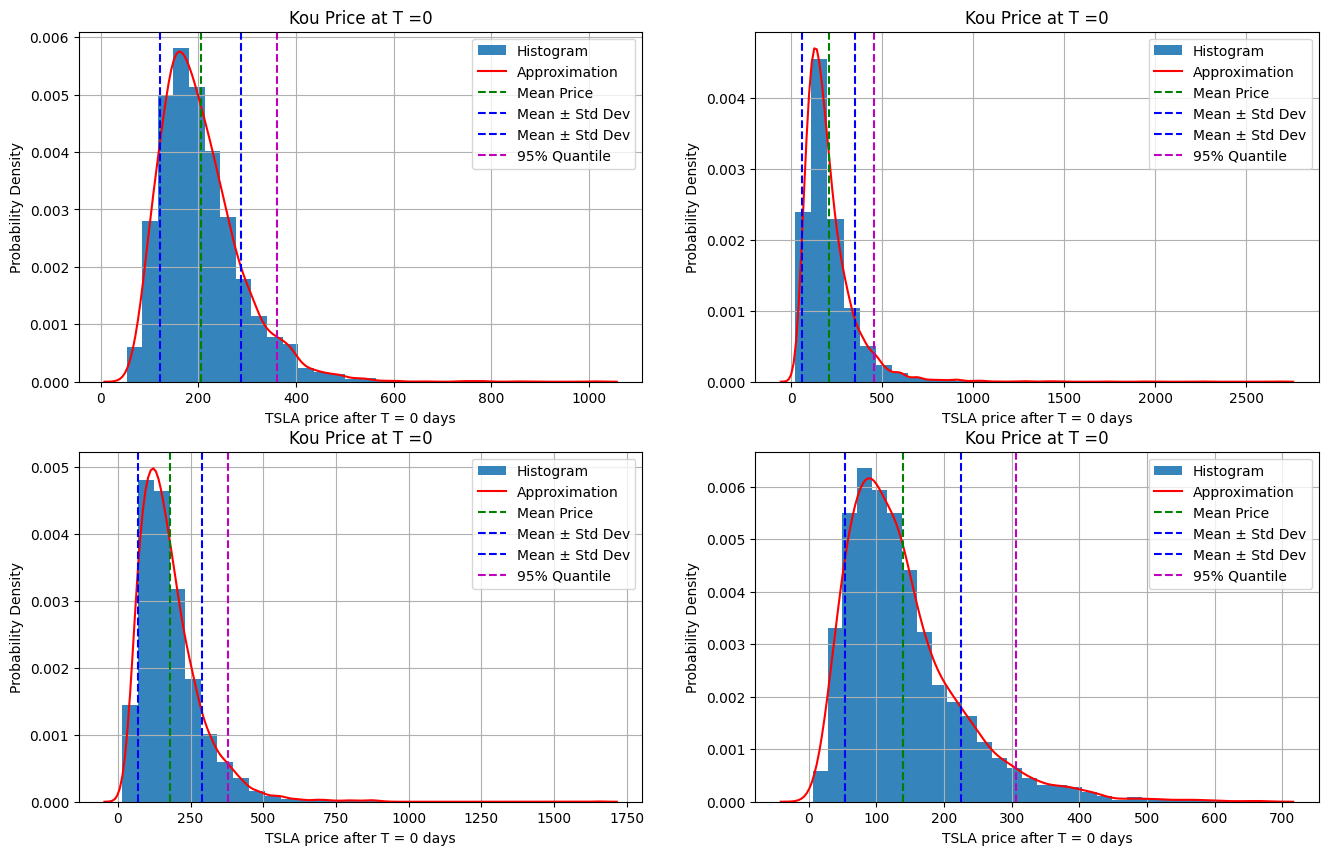

In [22]:
print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> European CALLS:\t {k_params_calls}')
print(f'> European PUTS:\t  {k_params_puts}')
print(f'> OTKO DC:\t\t\t {k_params_otko}')
print(f'> MIXED:\t\t\t\t {k_params_mixed}')

Kou1 = Kou_pricer(S0, None, T, r, k_params_calls[0], k_params_calls[1], k_params_calls[2], k_params_calls[3], k_params_calls[4], exercise)
Kou2 = Kou_pricer(S0, None, T, r, k_params_puts[0], k_params_puts[1], k_params_puts[2], k_params_puts[3], k_params_puts[4], exercise)
Kou3 = Kou_pricer(S0, None, T, r, k_params_otko[0], k_params_otko[1], k_params_otko[2], k_params_otko[3], k_params_otko[4], exercise)
Kou4 = Kou_pricer(S0, None, T, r, k_params_mixed[0], k_params_mixed[1], k_params_mixed[2], k_params_mixed[3], k_params_mixed[4], exercise)

SKou1 = Kou1.KouPath(days, paths)
SKou2 = Kou2.KouPath(days, paths)
SKou3 = Kou3.KouPath(days, paths)
SKou4 = Kou4.KouPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
Kou1.plotKouPath(SKou1, 'TSLA', ax=axes[0,0])
Kou2.plotKouPath(SKou2, 'TSLA', ax=axes[0,1])
Kou3.plotKouPath(SKou3, 'TSLA', ax=axes[1,0])
Kou4.plotKouPath(SKou4, 'TSLA', ax=axes[1,1])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
Kou1.plotKouAtFixedTime(SKou1, -1, 'TSLA', ax = axes[0,0])
Kou2.plotKouAtFixedTime(SKou2, -1, 'TSLA', ax = axes[0,1])
Kou3.plotKouAtFixedTime(SKou3, -1, 'TSLA', ax = axes[1,0])
Kou4.plotKouAtFixedTime(SKou4, -1, 'TSLA', ax = axes[1,1])

Compute the otko final prices for Kou model

In [23]:
avg_payoffs = []
for k in calls_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou4[-1]:
        payoffs.append(Kou4.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(calls_calib_prices))
kou_cf_prices = np.zeros(len(calls_calib_prices))

for index in range(len(calls_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = Kou4.closed_formula_call(calls_strikes[index])

calls_calib_prices['KOU MC (%)'] = kou_mc_prices
calls_calib_prices['KOU CF (%)'] = kou_cf_prices

avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou4[-1]:
        payoffs.append(Kou4.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(puts_calib_prices))
kou_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = Kou4.closed_formula_put(puts_strikes[index])

puts_calib_prices['KOU MC (%)'] = kou_mc_prices
puts_calib_prices['KOU CF (%)'] = kou_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou4.T:
        payoffs.append(Kou4.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(otko_calib_prices))
kou_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = Kou4.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['KOU MC (%)'] = kou_mc_prices
otko_calib_prices['KOU CF (%)'] = kou_cf_prices

In [24]:
selection1 = [0,1,2,3,6,7]
print(f'>> CALLS\n{calls_calib_prices.iloc[:, selection1]}')
print(f'>> PUTS\n{puts_calib_prices.iloc[:, selection1]}')
selection2 = [0,1,2,3,4,7,8]
print(f'\n>> OTKO\n{otko_calib_prices.iloc[:, selection2]}')

>> CALLS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  KOU MC (%)  KOU CF (%)
0   150.0    58.64   59.725    60.81   27.355200   66.398087
1   170.0    46.79   47.595    48.40   21.430976   54.640414
2   195.0    34.09   34.950    35.81   15.741257   42.479443
3   200.0    31.90   32.775    33.65   14.779877   40.359930
4   230.0    21.55   22.920    24.29   10.111541   29.567470
5   260.0    13.51   14.430    15.35    6.937696   21.566537
>> PUTS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  KOU MC (%)  KOU CF (%)
0   150.0    18.55   19.245    19.94   37.616818   13.264917
1   165.0    24.55   25.175    25.80   47.603046   18.827943
2   195.0    39.16   39.880    40.60   69.672924   33.016322
3   200.0    42.10   42.900    43.70   73.563772   35.749037
4   220.0    54.46   55.230    56.00   89.676543   47.618319
5   250.0    75.66   76.150    76.64  115.168574   67.876849

>> OTKO
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  KOU MC (%)  KOU CF (%)
0  75   0         1.76         1.91         2.0

#### Variance Gamma model

CALIBRATED PARAMETERS: [σ 		θ		 v]
> European CALLS:	 [0.3917, -0.0513, 0.234]
> European PUTS:	 [0.6148, 0.1586, 0.3572]
> OTKO DC:			 [0.4543, -0.2538, 0.1375]
> MIXED:		 [0.3252, -0.17, 1.9983]
CALIBRATED PARAMETERS: [μ_p	 μ_n	v_p	v_n]
> European CALLS:	 [0.547, 0.599, 0.07, 0.084]
> European PUTS:	 [0.811, 0.652, 0.235, 0.152]
> OTKO DC:			 [0.749, 1.002, 0.077, 0.138]
> MIXED:			 [0.099, 0.269, 0.019, 0.144]


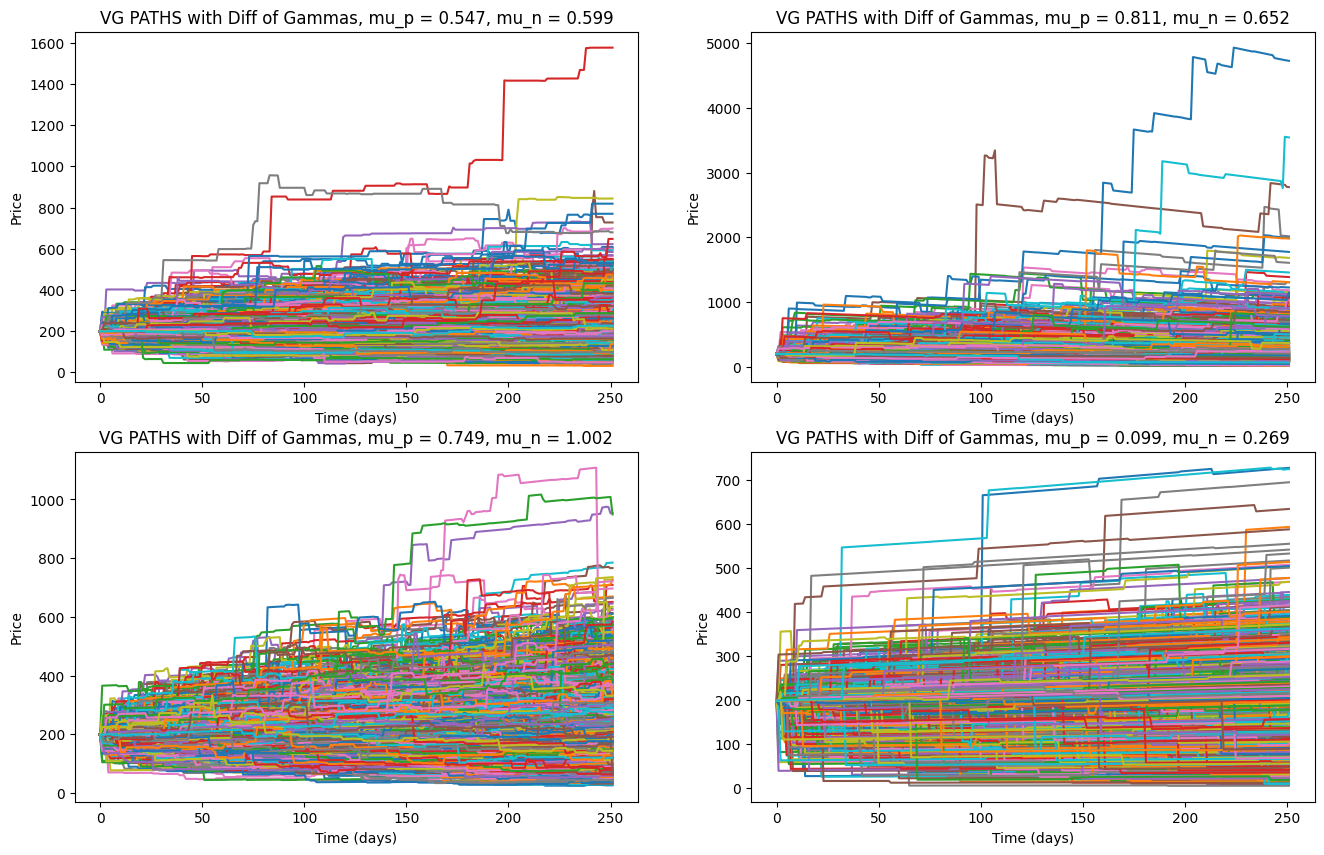

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

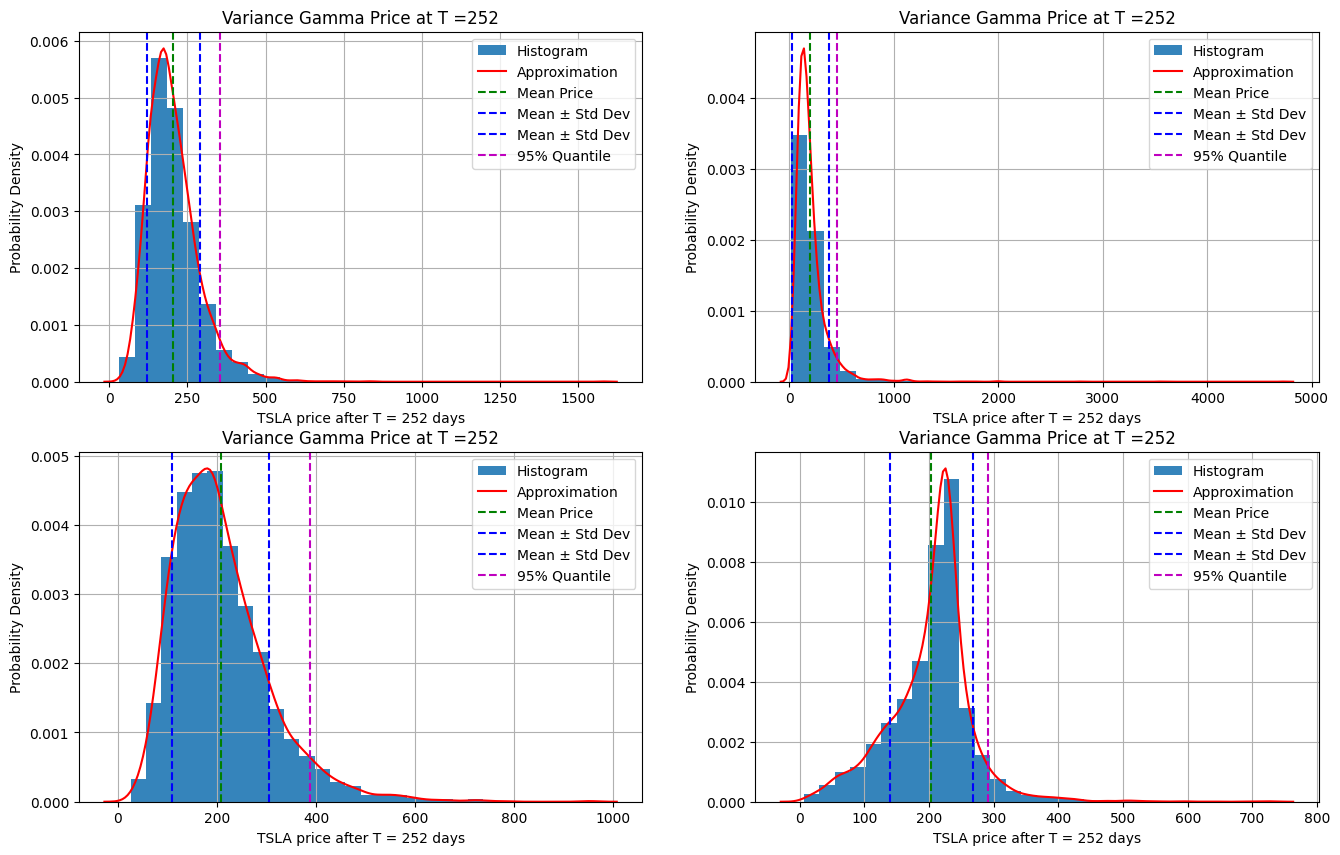

In [25]:
VG1 = VG_pricer(S0, None, T, r, q, vg_params_calls[0], vg_params_calls[1], vg_params_calls[2],  exercise)
VG2 = VG_pricer(S0, None, T, r, q, vg_params_puts[0], vg_params_puts[1], vg_params_puts[2],  exercise)
VG3 = VG_pricer(S0, None, T, r, q, vg_params_otko[0], vg_params_otko[1], vg_params_otko[2], exercise)
VG4 = VG_pricer(S0, None, T, r, q, vg_params_mixed[0], vg_params_mixed[1], vg_params_mixed[2], exercise)

print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European CALLS:\t {vg_params_calls}')
print(f'> European PUTS:\t {vg_params_puts}')
print(f'> OTKO DC:\t\t\t {vg_params_otko}')
print(f'> MIXED:\t\t {vg_params_mixed}')

vg_params_calls2 = [VG1.get_mu_p, VG1.get_mu_n, VG1.get_nu_p, VG1.get_nu_n]
vg_params_puts2 = [VG2.get_mu_p, VG2.get_mu_n, VG2.get_nu_p, VG2.get_nu_n]
vg_params_otko2 = [VG3.get_mu_p, VG3.get_mu_n, VG3.get_nu_p, VG3.get_nu_n]
vg_params_mixed2 = [VG4.get_mu_p, VG4.get_mu_n, VG4.get_nu_p, VG4.get_nu_n]

for i in range(len(vg_params_calls2)):
    vg_params_calls2[i] = round(vg_params_calls2[i], 3)
    vg_params_puts2[i] = round(vg_params_puts2[i], 3)
    vg_params_otko2[i] = round(vg_params_otko2[i], 3)
    vg_params_mixed2[i] = round(vg_params_mixed2[i], 3)

print(f'CALIBRATED PARAMETERS: [μ_p\t μ_n\tv_p\tv_n]')
print(f'> European CALLS:\t {vg_params_calls2}')
print(f'> European PUTS:\t {vg_params_puts2}')
print(f'> OTKO DC:\t\t\t {vg_params_otko2}')
print(f'> MIXED:\t\t\t {vg_params_mixed2}')

SVG1 = VG1.VarianceGammaPath2(days, paths)
SVG2 = VG2.VarianceGammaPath2(days, paths)
SVG3 = VG3.VarianceGammaPath2(days, paths)
SVG4 = VG4.VarianceGammaPath2(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
VG1.plotVGPath(SVG1, 'TSLA', method='Diff of Gammas', ax=axes[0,0])
VG2.plotVGPath(SVG2, 'TSLA',method='Diff of Gammas', ax=axes[0,1])
VG3.plotVGPath(SVG3, 'TSLA', method='Diff of Gammas', ax=axes[1,0])
VG4.plotVGPath(SVG4, 'TSLA', method='Diff of Gammas', ax=axes[1,1])
plt.tight_layout()
plt.show()


# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
VG1.plotVGAtFixedTime(SVG1, 251, 'TSLA', ax = axes[0,0])
VG2.plotVGAtFixedTime(SVG2, 251, 'TSLA', ax = axes[0,1])
VG3.plotVGAtFixedTime(SVG3, 251, 'TSLA', ax = axes[1,0])
VG4.plotVGAtFixedTime(SVG4, 251, 'TSLA', ax = axes[1,1])

In [26]:
avg_payoffs = []
for k in calls_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVG4[-1]:
        payoffs.append(VG4.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(calls_calib_prices))
vg_cf_prices = np.zeros(len(calls_calib_prices))

for index in range(len(calls_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VG4.closed_formula_call(calls_strikes[index])

calls_calib_prices['VG MC (%)'] = vg_mc_prices
calls_calib_prices['VG CF (%)'] = vg_cf_prices

avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVG4[-1]:
        payoffs.append(VG4.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(puts_calib_prices))
vg_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VG4.closed_formula_put(puts_strikes[index])

puts_calib_prices['VG MC (%)'] = vg_mc_prices
puts_calib_prices['VG CF (%)'] = vg_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVG4.T:
        payoffs.append(VG4.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(otko_calib_prices))
vg_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    vg_cf_prices[index] = VG4.closed_formula_otko8(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['VG MC (%)'] = vg_mc_prices
otko_calib_prices['VG CF (%)'] = vg_cf_prices

In [27]:
selection1 = [0,1,2,3,8,9]
print(f'>> CALLS\n{calls_calib_prices.iloc[:, selection1]}')
print(f'>> CALLS\n{puts_calib_prices.iloc[:, selection1]}')
selection2 = [0,1,2,3,4,9,10]
print(f'\n>> OTKO\n{otko_calib_prices.iloc[:, selection2]}')

>> CALLS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  VG MC (%)  VG CF (%)
0   150.0    58.64   59.725    60.81  59.628227  58.107732
1   170.0    46.79   47.595    48.40  44.336454  47.850501
2   195.0    34.09   34.950    35.81  27.331059  39.746745
3   200.0    31.90   32.775    33.65  24.281882  38.467225
4   230.0    21.55   22.920    24.29  10.158103  32.295727
5   260.0    13.51   14.430    15.35   5.073431  27.872650
>> CALLS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  VG MC (%)  VG CF (%)
0   150.0    18.55   19.245    19.94   8.003317   4.974562
1   165.0    24.55   25.175    25.80  10.972521  11.374099
2   195.0    39.16   39.880    40.60  19.376198  30.283624
3   200.0    42.10   42.900    43.70  21.179249  33.856331
4   220.0    54.46   55.230    56.00  30.110590  48.909157
5   250.0    75.66   76.150    76.64  51.697300  73.113869

>> OTKO
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  VG MC (%)  VG CF (%)
0  75   0         1.76         1.91         2.07   4.128072   4.547301
1  70

In [28]:
print(calls_calib_prices)
print(puts_calib_prices)
print(otko_calib_prices)

   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)  \
0   150.0    58.64   59.725    60.81      64.476455      66.795521   
1   170.0    46.79   47.595    48.40      51.464026      54.713572   
2   195.0    34.09   34.950    35.81      37.951983      42.320761   
3   200.0    31.90   32.775    33.65      35.613930      40.181192   
4   230.0    21.55   22.920    24.29      24.041279      29.435808   
5   260.0    13.51   14.430    15.35      15.909248      21.696871   

   KOU MC (%)  KOU CF (%)  VG MC (%)  VG CF (%)  
0   27.355200   66.398087  59.628227  58.107732  
1   21.430976   54.640414  44.336454  47.850501  
2   15.741257   42.479443  27.331059  39.746745  
3   14.779877   40.359930  24.281882  38.467225  
4   10.111541   29.567470  10.158103  32.295727  
5    6.937696   21.566537   5.073431  27.872650  
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)  \
0   150.0    18.55   19.245    19.94      13.686155      13.662351   
1   165.0    24.55 